# 06 Post-Deployment Analysis (MIT Timing + Proxy Lag)

**Goal:** Characterize how risks manifest pre- vs post-deployment (MIT timing) and provide a cautious lag proxy.

This notebook:
- Summarizes MIT timing distribution
- Compares risk domains across timing
- Provides a **lag proxy** using URL-merged subset (submissions ↔ reports) when possible

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

mit = pd.read_csv(DATA / "classifications_MIT.csv") if (DATA / "classifications_MIT.csv").exists() else None
rep = pd.read_csv(DATA / "reports.csv")
sub = pd.read_csv(DATA / "submissions.csv")

rep.columns = [c.strip().lower() for c in rep.columns]
sub.columns = [c.strip().lower() for c in sub.columns]
if mit is not None: mit.columns = [c.strip().lower() for c in mit.columns]

if mit is not None and "incident id" in mit.columns and "incident_id" not in mit.columns:
    mit = mit.rename(columns={"incident id": "incident_id"})

print("MIT:", None if mit is None else mit.shape)
print("Reports:", rep.shape)
print("Submissions:", sub.shape)

MIT: (1242, 8)
Reports: (6687, 21)
Submissions: (45, 15)


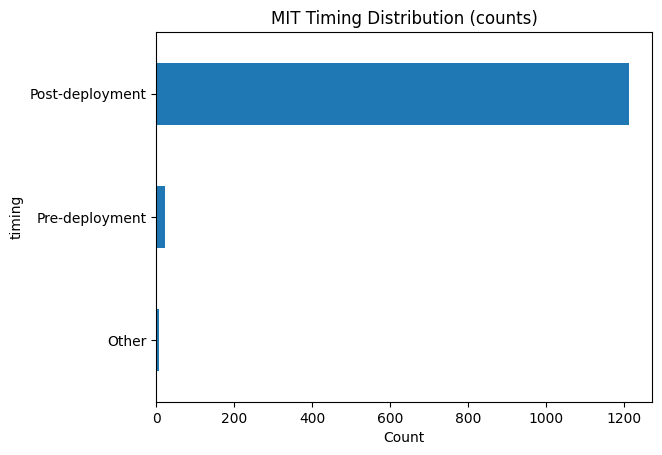

MIT Timing (%):


timing
Post-deployment    97.5
Pre-deployment      1.9
Other               0.6
Name: count, dtype: float64

In [2]:
def savefig(fig, name):
    fig.savefig(OUT / name, bbox_inches="tight", dpi=200)

if mit is None or "timing" not in mit.columns:
    print("MIT timing column not found.")
else:
    vc = mit["timing"].dropna().astype(str).value_counts()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vc.sort_values().plot(kind="barh", ax=ax)
    ax.set_title("MIT Timing Distribution (counts)")
    ax.set_xlabel("Count")
    savefig(fig, "80_mit_timing_counts.png")
    plt.show()

    pct = (vc / vc.sum() * 100).round(1)
    print("MIT Timing (%):")
    display(pct)

In [3]:
if mit is not None and {"risk_domain", "timing"}.issubset(set(mit.columns)):
    df = mit.dropna(subset=["risk_domain", "timing"]).copy()
    df["risk_domain"] = df["risk_domain"].astype(str)
    df["timing"] = df["timing"].astype(str)

    top_domains = df["risk_domain"].value_counts().head(12).index
    df = df[df["risk_domain"].isin(top_domains)]

    ct = pd.crosstab(df["timing"], df["risk_domain"], normalize="index")
    ct_pct = (ct * 100).round(1)
    print("Risk domains by timing (% within timing):")
    display(ct_pct)

    ct_pct.to_csv(OUT / "81_domain_by_timing_pct.csv")
else:
    print("MIT missing risk_domain or timing; skipping domain-by-timing.")

MIT missing risk_domain or timing; skipping domain-by-timing.


Lag proxy report date column: date_published_rep
Lag sample size: 0


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

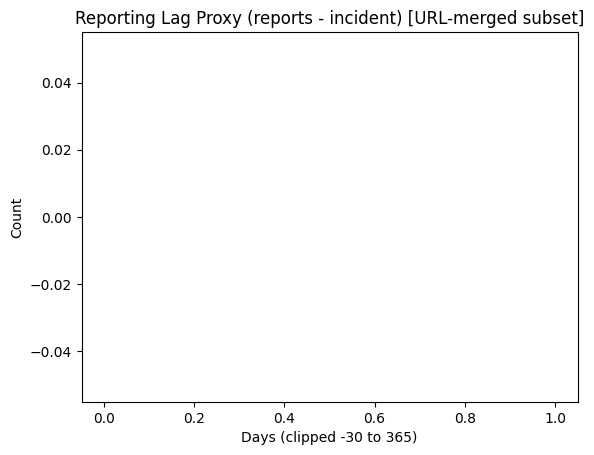

In [4]:
# Proxy lag using submissions ↔ reports merge on URL (subset only)
if "url" in sub.columns and "url" in rep.columns:
    merged = sub.merge(rep, on="url", how="inner", suffixes=("_sub", "_rep"))

    merged["_incident_dt"] = pd.to_datetime(merged.get("incident_date"), errors="coerce", utc=True).dt.tz_convert(None)

    report_date_candidates = [
        "date_published_rep", "date_published",
        "date_submitted_rep", "date_submitted",
        "date_modified_rep", "date_modified",
        "date_downloaded_rep", "date_downloaded",
    ]
    rep_date_col2 = next((c for c in report_date_candidates if c in merged.columns), None)
    print("Lag proxy report date column:", rep_date_col2)

    if rep_date_col2 is None:
        print("No report date column found after merge. Date-like columns:", [c for c in merged.columns if "date" in c])
    else:
        merged["_published_dt"] = pd.to_datetime(merged[rep_date_col2], errors="coerce", utc=True).dt.tz_convert(None)
        lag_days = (merged["_published_dt"] - merged["_incident_dt"]).dt.days.dropna()

        print("Lag sample size:", len(lag_days))
        display(lag_days.describe())

        fig = plt.figure()
        ax = fig.add_subplot(111)
        lag_days.clip(lower=-30, upper=365).plot(kind="hist", bins=40, ax=ax)
        ax.set_title("Reporting Lag Proxy (reports - incident) [URL-merged subset]")
        ax.set_xlabel("Days (clipped -30 to 365)")
        ax.set_ylabel("Count")
        savefig(fig, "82_reporting_lag_proxy_hist.png")
        plt.show()
else:
    print("Missing url in submissions or reports; skipping lag proxy.")

## Notes & Limitations

- MIT timing reflects when the risk manifests relative to deployment, but relies on taxonomy coding.
- The lag histogram is a **proxy** computed on a small URL-merged subset only.
- Without a complete incident↔report mapping, we avoid claiming full reporting lag statistics.